**Load data**

In [22]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

# Cloud type index = 37
# clear = 0
# stratus continental = 1
# stratus maritime = 2
# cumulus continental clean = 3
# cumulus continental polluted = 4
# cumulus maritime = 5
# cirrus = 6
# cirrus + water clouds (mixed) >= 7

DAY_TIME = False
USE_MIXED = False
USE_PRESSURE_TEMP = True
USE_SPECIFIC_CLOUDS = False
LOW_VIS_FRAC = False
low_vis_frac = 0.50
low_vis_threshold = 1000 #50000
cloud_types = [6] #0,1,2 ::: 0, 3, 4
noise_level = 0.01 # fraction of max - min
dnn_batch_size = 64

if USE_MIXED:
    filenames_vis = ['fog_data2_vis_clear.dat', 'fog_data2_vis_ice.dat', 'fog_data2_vis_mixed.dat', 'fog_data2_vis_water.dat']
    filenames_ir = ['fog_data2_ir_clear.dat', 'fog_data2_ir_ice.dat', 'fog_data2_ir_mixed.dat', 'fog_data2_ir_water.dat']
else:
    filenames_vis = ['fog_data2_vis_clear.dat', 'fog_data2_vis_ice.dat', 'fog_data2_vis_water.dat']
    filenames_ir = ['fog_data2_ir_clear.dat', 'fog_data2_ir_ice.dat', 'fog_data2_ir_water.dat']

target_i = 30 # Visibility index
if USE_PRESSURE_TEMP:
    features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,36))) # 13 ir bands, 10 vis bands, 3 angles, pressure, temp
else:
    features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,34)))

# Combine .dat files into one numpy array
data_ir_vis = []
for file_ir, file_vis in zip(filenames_ir, filenames_vis):
  raw_data_ir = pd.read_csv('fog_dataset2/' + file_ir).to_numpy()
  raw_data_vis = pd.read_csv('fog_dataset2/' + file_vis).to_numpy()

  data_ir = np.array([row[0].split() for row in raw_data_ir[25:]])
  data_vis = np.array([row[0].split()[1:] for row in raw_data_vis[41:]])

  if len(data_ir_vis) == 0:
    data_ir_vis = np.hstack([data_ir, data_vis])
  else:
    data_ir_vis = np.vstack([data_ir_vis, np.hstack([data_ir, data_vis])])

# Remove surface description to convert to float
data_ir_vis = data_ir_vis[:,:-1] 
data_ir_vis = data_ir_vis.astype(np.float32)

# Some data points contains nan. Not sure why. Band 32 culprit, 8th feature
nan_i = np.where(np.isnan(data_ir_vis))[0]
data_ir_vis = np.delete(data_ir_vis, nan_i, axis=0)

# Cloud type index = 37
if USE_SPECIFIC_CLOUDS:
   data_ir_vis = data_ir_vis[np.isin(data_ir_vis[:, 37], cloud_types)]

if DAY_TIME:
   #data_ir_vis = data_ir_vis[np.where(np.abs(data_ir_vis[:, 33] - 90) < 30)[0]]
   data_ir_vis = data_ir_vis[np.where(data_ir_vis[:, 32] < 30)[0]]



X = data_ir_vis[:, features_i]
y = data_ir_vis[:,target_i]

noise_std_devs = np.zeros(features_i.shape)

for i, feature_i in enumerate(features_i):
    noise_std = (np.max(data_ir_vis[:,feature_i]) - np.min(data_ir_vis[:,feature_i])) * noise_level # 1% of mean or max??
    noise_std_devs[i] = noise_std

# Scaling features and noise standard deviations
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)
noise_stds_scaled = np.divide(noise_std_devs, feature_scaler.scale_)

# Scaling target
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1))


# First split: Separate out a test set (5% of the original dataset)
X_temp, X_test, y_temp, y_test_reg = train_test_split(X_scaled, y_scaled, test_size=(1/20))


if LOW_VIS_FRAC:
    low_vis_i = np.where(target_scaler.inverse_transform(y_temp) < low_vis_threshold)[0]
    high_vis_i = np.where(target_scaler.inverse_transform(y_temp) >= low_vis_threshold)[0]

    n_high_vis = int(len(low_vis_i) / low_vis_frac * (1 - low_vis_frac))
    print(f'real frac: {len(low_vis_i)/len(y_scaled)}')
    if n_high_vis > len(high_vis_i):
        n_high_vis = len(high_vis_i)
        n_low_vis = int(low_vis_frac * n_high_vis)
        r_low_vis_i = np.random.choice(low_vis_i, n_low_vis, replace=False)
        low_vis_i = r_low_vis_i
    print(f'n_low_vis: {len(low_vis_i)}. n_high_vis: {n_high_vis}')
    r_high_vis_i = np.random.choice(high_vis_i, n_high_vis, replace=False)
    X_temp = np.vstack([X_temp[low_vis_i], X_temp[r_high_vis_i]])
    y_temp = np.vstack([y_temp[low_vis_i], y_temp[r_high_vis_i]])


# Second split: Split the remaining data into training and validation sets
X_train, X_val, y_train_reg, y_val_reg = train_test_split(X_temp, y_temp, test_size=(1/19))

# Create noisy data
X_train_noisy = X_train + np.multiply(np.random.normal(0, 1, X_train.shape), noise_stds_scaled)
X_val_noisy = X_val + np.multiply(np.random.normal(0, 1, X_val.shape), noise_stds_scaled)
X_test_noisy = X_test + np.multiply(np.random.normal(0, 1, X_test.shape), noise_stds_scaled)

# Create class labels
y_train_class = np.where(target_scaler.inverse_transform(y_train_reg) < low_vis_threshold, 1, 0)
y_val_class = np.where(target_scaler.inverse_transform(y_val_reg) < low_vis_threshold, 1, 0)
y_test_class = np.where(target_scaler.inverse_transform(y_test_reg) < low_vis_threshold, 1, 0)


# Create training data for DNN that adds noise to batches
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train_reg)).batch(batch_size=dnn_batch_size)
training_data_class = tf.data.Dataset.from_tensor_slices((X_train, y_train_class)).batch(batch_size=dnn_batch_size)

def noise_map(features, labels):
    noise = tf.random.normal(shape=tf.shape(features))
    noise = noise * noise_stds_scaled
    noisy_features = features + noise
    return noisy_features, labels

training_data = training_data.map(noise_map)
training_data_class = training_data_class.map(noise_map)

MSE: 0.8965743184089661


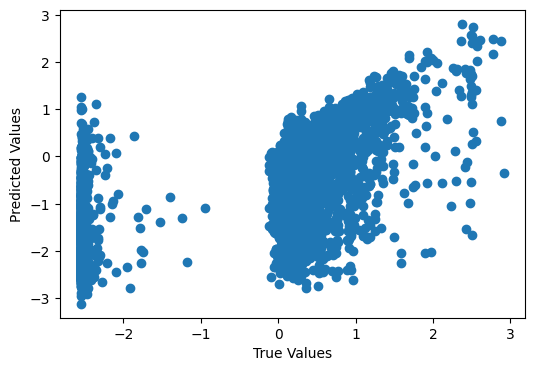

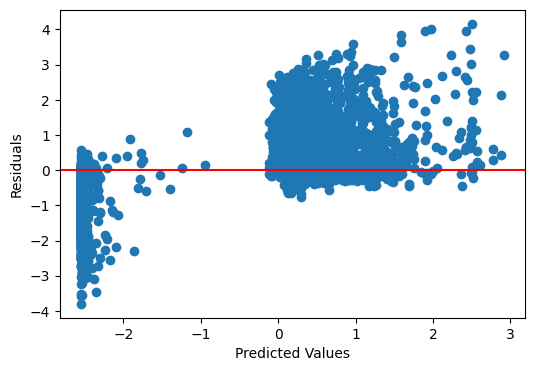

In [20]:
import xgboost as xgb
from sklearn.metrics import classification_report

#neg_to_pos_ratio = (len(y_train_class) - np.sum(y_train_class)) / np.sum(y_train_class)


dtrain = xgb.DMatrix(X_train_noisy, label=y_train_reg)
dtest = xgb.DMatrix(X_test_noisy, label=y_test_reg)

params = {
    'objective': 'reg:squarederror',  # For regression
    'max_depth': 10,  # Maximum tree depth
    'learning_rate': 0.05,
    'subsample': 0.8,
    #'scale_pos_weight': neg_to_pos_ratio,
   # ... other parameters (Refer to XGBoost documentation)
}
num_rounds = 1000  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)
y_pred_reg = model.predict(dtest)
residuals = y_test_reg.ravel() - y_pred_reg


print(f'MSE: {mean_squared_error(y_test_reg.ravel(), y_pred_reg)}')
# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test_reg, y_pred_reg)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test_reg, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

**Classification models**

              precision    recall  f1-score   support

           0       0.98      0.75      0.85     20471
           1       0.25      0.84      0.39      2028

    accuracy                           0.76     22499
   macro avg       0.62      0.80      0.62     22499
weighted avg       0.91      0.76      0.81     22499



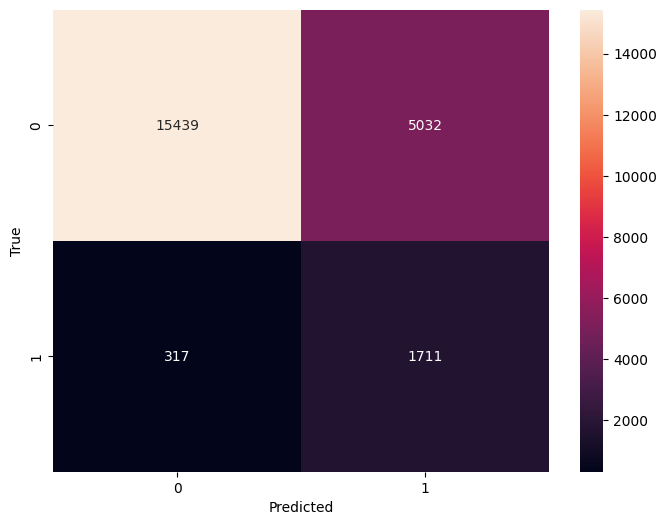

In [21]:
import xgboost as xgb
from sklearn.metrics import classification_report

neg_to_pos_ratio = (len(y_train_class) - np.sum(y_train_class)) / np.sum(y_train_class)

dtrain = xgb.DMatrix(X_train_noisy, label=y_train_class)
dtest = xgb.DMatrix(X_test_noisy, label=y_test_class)

params = {
    'objective': 'binary:logistic',  # For binary classification
    'max_depth': 16,  # Maximum tree depth
    'learning_rate': 0.05,  # Learning rate
    #'scale_pos_weight': neg_to_pos_ratio,
   # ... other parameters (Refer to XGBoost documentation)
}
num_rounds = 1000  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)
predictions_1 = model.predict(dtest)
y_pred_class = (predictions_1 > 0.5 ).astype(int) 

print(classification_report(y_test_class, y_pred_class))
cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize=(8,6))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     20428
           1       0.67      0.19      0.29      2071

    accuracy                           0.92     22499
   macro avg       0.80      0.59      0.62     22499
weighted avg       0.90      0.92      0.89     22499



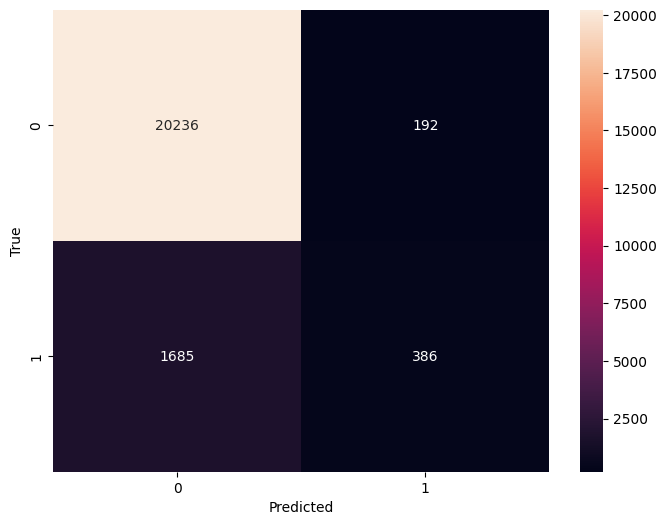

In [23]:
import xgboost as xgb
from sklearn.metrics import classification_report

neg_to_pos_ratio = (len(y_train_class) - np.sum(y_train_class)) / np.sum(y_train_class)

dtrain = xgb.DMatrix(X_train_noisy, label=y_train_class)
dtest = xgb.DMatrix(X_test_noisy, label=y_test_class)

params = {
    'objective': 'binary:logistic',  # For binary classification
    'max_depth': 16,  # Maximum tree depth
    'learning_rate': 0.05,  # Learning rate
    #'scale_pos_weight': neg_to_pos_ratio,
   # ... other parameters (Refer to XGBoost documentation)
}
num_rounds = 1000  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)
predictions_2 = model.predict(dtest)
y_pred_class = (predictions_2 > 0.5 ).astype(int) 

print(classification_report(y_test_class, y_pred_class))
cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Epoch 1/10


/home/edgelab/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9082 - loss: 0.0636 - val_accuracy: 0.9031 - val_loss: 0.0470
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9067 - loss: 0.0452 - val_accuracy: 0.9031 - val_loss: 0.0445
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9107 - loss: 0.0413 - val_accuracy: 0.9138 - val_loss: 0.0389
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9196 - loss: 0.0370 - val_accuracy: 0.9151 - val_loss: 0.0380
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9177 - loss: 0.0366 - val_accuracy: 0.9138 - val_loss: 0.0376
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9155 - loss: 0.0370 - val_accuracy: 0.9133 - val_loss: 0.0376
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9176 - loss: 0.0354 - val_accuracy: 0.9160 - val_loss: 0.0369
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9147 - loss: 0.0356 - val_accuracy: 0.9169 - val_

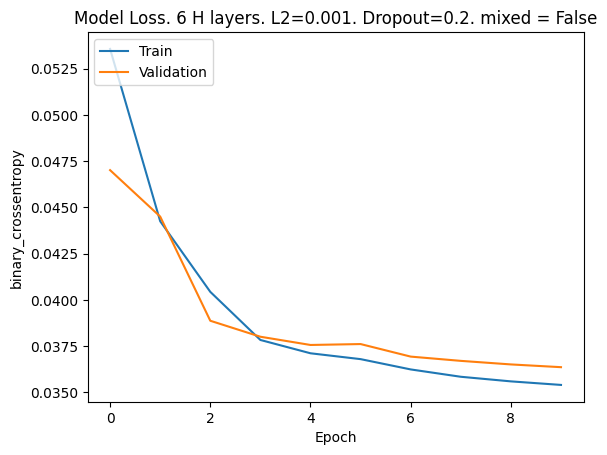

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2048
           1       0.70      0.26      0.38       202

    accuracy                           0.92      2250
   macro avg       0.81      0.63      0.67      2250
weighted avg       0.91      0.92      0.91      2250



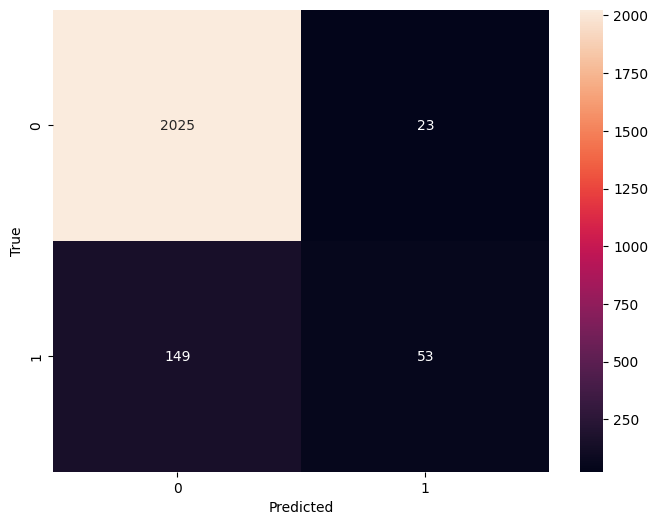

In [28]:
X_pred = np.stack((predictions_1, predictions_2), axis=-1)
y_test_class

# Split x_train and y_train into training and testing sets 
# (Let's use an 80/20 split)
X_train, X_temp, y_train, y_temp = train_test_split(X_pred, y_test_class, test_size=0.2, random_state=42) 

# Split the temporary set (X_temp, y_temp) into validation and test sets
# (Let's use a 50/50 split on the remaining data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


from keras import layers
from keras import regularizers
from keras.layers import Attention
from sklearn.metrics import classification_report
from keras.losses import BinaryFocalCrossentropy



# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(2, activation='relu', input_shape=(2,)),
    
    # Hidden layers
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Output layer
    layers.Dense(1, activation='sigmoid') 
])

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss = BinaryFocalCrossentropy(alpha=0.05, gamma=3, apply_class_balancing=False),
                 #loss='binary_crossentropy', 
                 metrics=['accuracy'])

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
history = ff_model.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val), verbose=1)


y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test, y_pred_label)


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# for t in thresholds:
#     y_pred_label = (y_pred > t ).astype(int)
#     plt.figure(figsize=(8,6)) 
#     sn.heatmap(confusion_matrix(y_test_label, y_pred_label), annot=True, fmt='d')
#     plt.title(f't = {t}')
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.show()


FFNN / MLP Classifier

Epoch 1/50


/home/edgelab/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


463/463 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6036 - loss: 0.2111 - val_accuracy: 0.6778 - val_loss: 0.0948
Epoch 2/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6988 - loss: 0.0870 - val_accuracy: 0.7076 - val_loss: 0.0761
Epoch 3/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7272 - loss: 0.0741 - val_accuracy: 0.7143 - val_loss: 0.0727
Epoch 4/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7381 - loss: 0.0715 - val_accuracy: 0.7264 - val_loss: 0.0715
Epoch 5/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7468 - loss: 0.0693 - val_accuracy: 0.7422 - val_loss: 0.0689
Epoch 6/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7588 - loss: 0.0679 - val_accuracy: 0.7429 - val_loss: 0.0691
Epoch 7/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7656 - loss: 0.0670 - val_accuracy: 0.7489 - val_loss: 0.0681
Epoch 8/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7721 - loss: 0.0655 - val_accuracy: 0.7599 - va

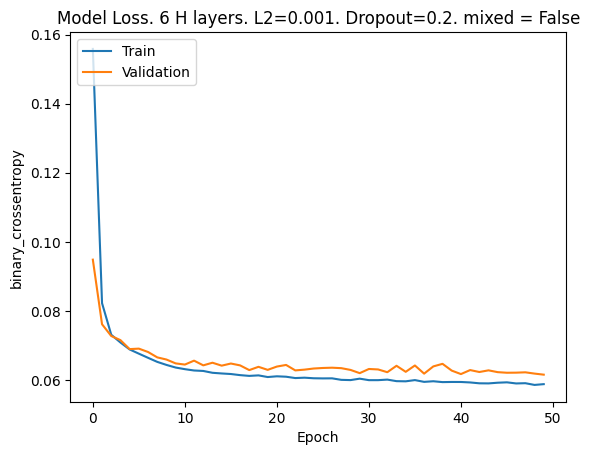

              precision    recall  f1-score   support

           0       0.99      0.75      0.85      7193
           1       0.27      0.89      0.41       735

    accuracy                           0.76      7928
   macro avg       0.63      0.82      0.63      7928
weighted avg       0.92      0.76      0.81      7928



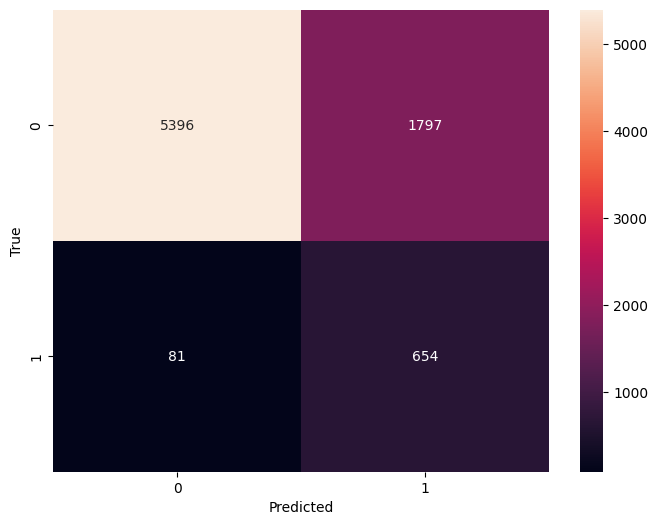

In [4]:
from keras import layers
from keras import regularizers
from keras.layers import Attention
from sklearn.metrics import classification_report
from keras.losses import BinaryFocalCrossentropy



# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),
    
    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Output layer
    layers.Dense(1, activation='sigmoid') 
])

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss = BinaryFocalCrossentropy(alpha=0.50, gamma=3, apply_class_balancing=False),
                 #loss='binary_crossentropy', 
                 metrics=['accuracy'])

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
history = ff_model.fit(training_data_class, epochs = 50, validation_data=(X_val_noisy, y_val_class), verbose=1)


y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_class, y_pred_label)


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_class, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# for t in thresholds:
#     y_pred_label = (y_pred > t ).astype(int)
#     plt.figure(figsize=(8,6)) 
#     sn.heatmap(confusion_matrix(y_test_label, y_pred_label), annot=True, fmt='d')
#     plt.title(f't = {t}')
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.show()


Random Forest Classifier

/home/edgelab/.local/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.98      0.90      0.94     13773
           1       0.40      0.78      0.53      1226

    accuracy                           0.89     14999
   macro avg       0.69      0.84      0.73     14999
weighted avg       0.93      0.89      0.90     14999



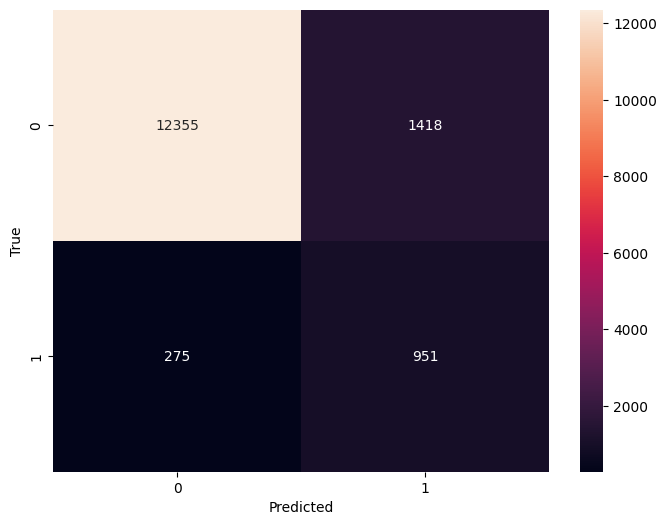

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_noisy, y_train_class)

y_pred_label = rf_model.predict(X_test_noisy)

print(classification_report(y_test_class, y_pred_label))
cm = confusion_matrix(y_test_class, y_pred_label)
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Gradient Boosted Classifier

/home/edgelab/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.98      0.87      0.92     13773
           1       0.35      0.78      0.48      1226

    accuracy                           0.86     14999
   macro avg       0.66      0.83      0.70     14999
weighted avg       0.93      0.86      0.89     14999



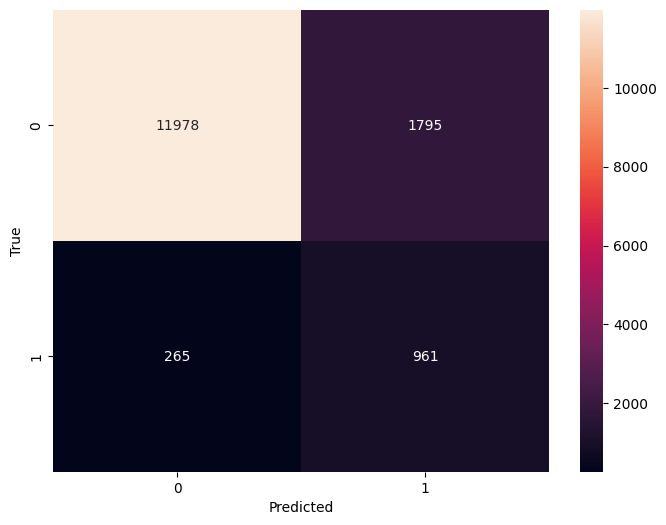

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

rf_model = GradientBoostingClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_noisy, y_train_class)

y_pred_label = rf_model.predict(X_test_noisy)

print(classification_report(y_test_class, y_pred_label))
cm = confusion_matrix(y_test_class, y_pred_label)
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Histograms of target value (visibility)**

All target values

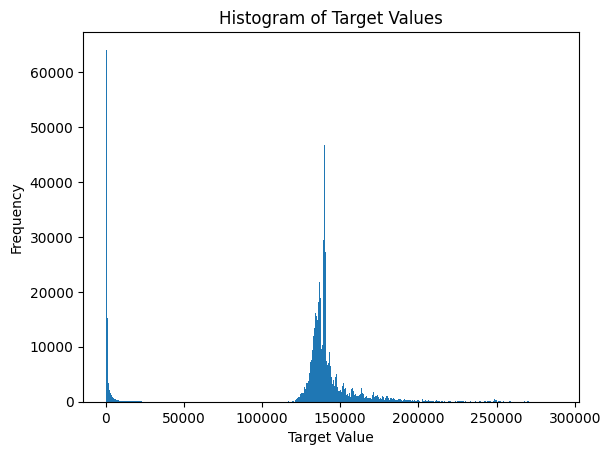

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(y, bins=500)
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.title("Histogram of Target Values")
plt.show()

Logarithm of all target values

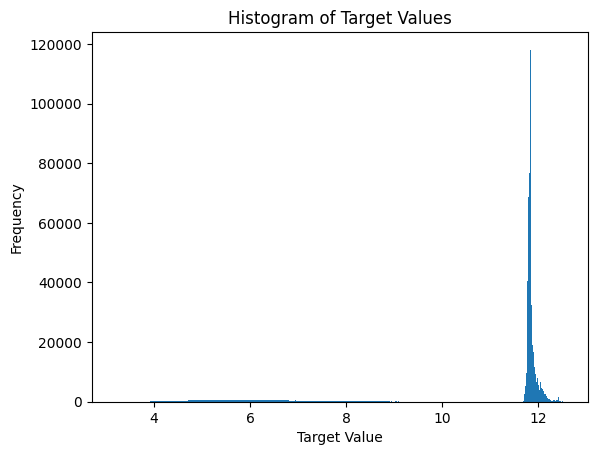

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(np.log(y), bins=500)
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.title("Histogram of Target Values")
plt.show()

"Low visibility" Target values

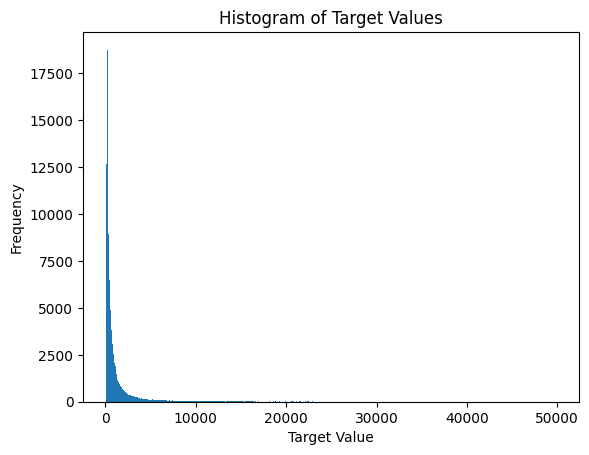

In [14]:
import matplotlib.pyplot as plt
import numpy as np

y_low_vis = y[y < low_vis_threshold]

plt.hist(y_low_vis, bins=500)
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.title("Histogram of Target Values")
plt.show()

Logarithm of "Low visibility" target values

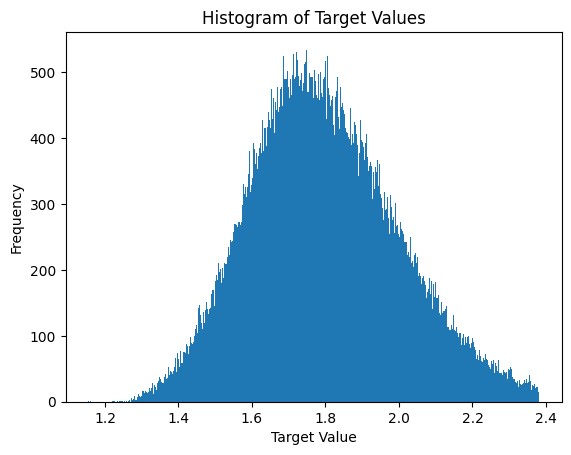

In [4]:
import matplotlib.pyplot as plt
import numpy as np

y_low_vis = y[y < low_vis_threshold]

plt.hist(np.log(np.log(y_low_vis)), bins=500)
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.title("Histogram of Target Values")
plt.show()

In [52]:
tmptmp = np.array([1,2,3,4])
tmptmpi = np.array([0,1,0,1])

mask = tmptmp < 3

print(mask)

[ True  True False False]


In [28]:
low_vis_i_train = np.where(target_scaler.inverse_transform(y_train_reg) < low_vis_threshold)[0]
X_low_vis_train = X_train_noisy[low_vis_i_train]
y_low_vis_train = np.log1p(target_scaler.inverse_transform(y_train_reg[low_vis_i_train]))
#y_low_vis_train = y_train[low_vis_i_train]


low_vis_i_val = np.where(target_scaler.inverse_transform(y_val_reg) < low_vis_threshold)[0]
X_low_vis_val = X_val_noisy[low_vis_i_val]
y_low_vis_val = target_scaler.inverse_transform(y_val_reg[low_vis_i_val])
#y_low_vis_val = y_val[low_vis_i_val]


low_vis_i_test = np.where(target_scaler.inverse_transform(y_test_reg) < low_vis_threshold)[0]
X_low_vis_test = X_test_noisy[low_vis_i_test]
y_low_vis_test = np.log1p(target_scaler.inverse_transform(y_test_reg[low_vis_i_test]))
#y_low_vis_test = y_test[low_vis_i_test]


low_vis_scaler = StandardScaler()
low_vis_scaler.fit(np.vstack([y_low_vis_train,  y_low_vis_val, y_low_vis_test]))


y_low_vis_train_scaled = low_vis_scaler.transform(y_low_vis_train)
y_low_vis_val_scaled = low_vis_scaler.transform(y_low_vis_val)
y_low_vis_test_scaled = low_vis_scaler.transform(y_low_vis_test)

MSE: 1.3178378343582153


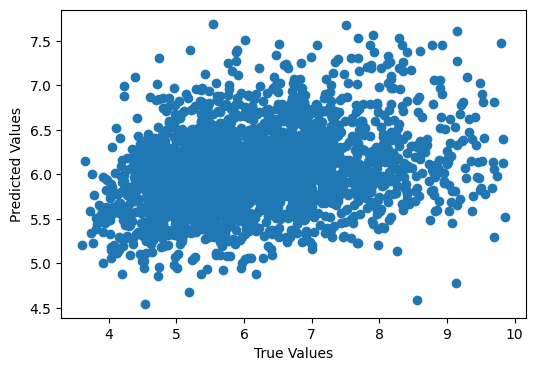

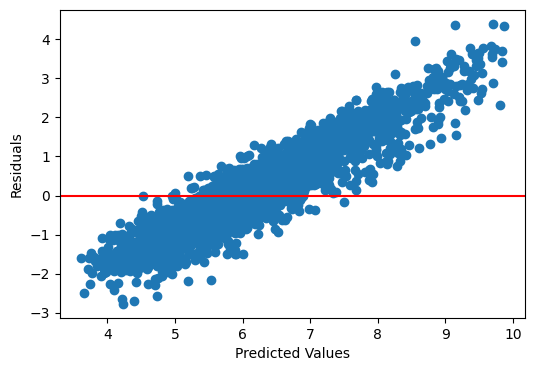

In [29]:
import xgboost as xgb
from sklearn.metrics import classification_report

#neg_to_pos_ratio = (len(y_train_class) - np.sum(y_train_class)) / np.sum(y_train_class)


dtrain = xgb.DMatrix(X_low_vis_train, label=y_low_vis_train)
dtest = xgb.DMatrix(X_low_vis_test, label=y_low_vis_test)

params = {
    'objective': 'reg:squaredlogerror',  # For regression
    'max_depth': 10,  # Maximum tree depth
    'learning_rate': 0.05,
    'subsample': 0.8,
    #'scale_pos_weight': neg_to_pos_ratio,
   # ... other parameters (Refer to XGBoost documentation)
}
num_rounds = 1000  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)
y_pred_reg = model.predict(dtest)
residuals = y_low_vis_test.ravel() - y_pred_reg


print(f'MSE: {mean_squared_error(y_low_vis_test.ravel(), y_pred_reg)}')
# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_low_vis_test, y_pred_reg)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_low_vis_test, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_low_vis_train, y_low_vis_train)

y_pred = rf_model.predict(X_low_vis_test)
mse = mean_squared_error(y_low_vis_test, y_pred)
residuals = y_low_vis_test.ravel() - y_pred 

print("Mean Squared Error:", mse)

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_low_vis_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_low_vis_test, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
#rf_model.fit(X_train_noisy, y_train.ravel())
rf_model.fit(X_low_vis, y_regression)

#y_pred = rf_model.predict(X_test)
y_pred = rf_model.predict(X_low_vis_test)
mse = mean_squared_error(y_regression_test, y_pred)
residuals = y_regression_test.ravel() - y_pred 

print("Mean Squared Error:", mse)

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_regression_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_regression_test, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()


Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, y_train_reg.ravel())

y_pred = gb_model.predict(X_test)
mse = mean_squared_error(y_test_reg, y_pred)
residuals = y_test_reg.ravel() - y_pred

print("Mean Squared Error:", mse)

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test_reg, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

DNN Regression

Epoch 1/50


/home/edgelab/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


517/517 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 4.8600 - mean_absolute_error: 1.5683 - val_loss: 1.0709 - val_mean_absolute_error: 0.7748
Epoch 2/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9258 - mean_absolute_error: 0.6945 - val_loss: 0.6488 - val_mean_absolute_error: 0.5707
Epoch 3/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7343 - mean_absolute_error: 0.6121 - val_loss: 0.5955 - val_mean_absolute_error: 0.5533
Epoch 4/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6779 - mean_absolute_error: 0.6008 - val_loss: 0.5757 - val_mean_absolute_error: 0.5532
Epoch 5/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6322 - mean_absolute_error: 0.5884 - val_loss: 0.5566 - val_mean_absolute_error: 0.5532
Epoch 6/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5961 - mean_absolute_error: 0.5795 - val_loss: 0.5884 - val_mean_absolute_error: 0.5786
Epoch 7/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5770 - mean_absolute_error: 0.5764 - val_loss: 0

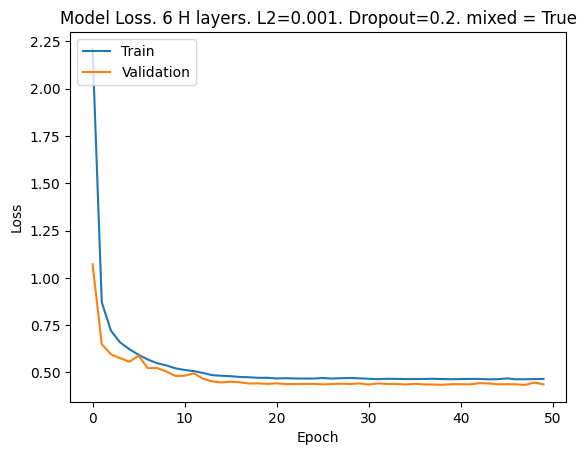

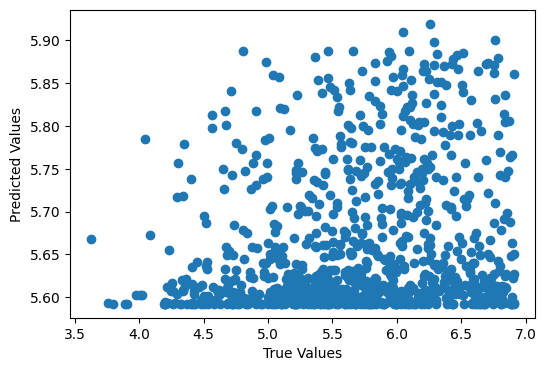

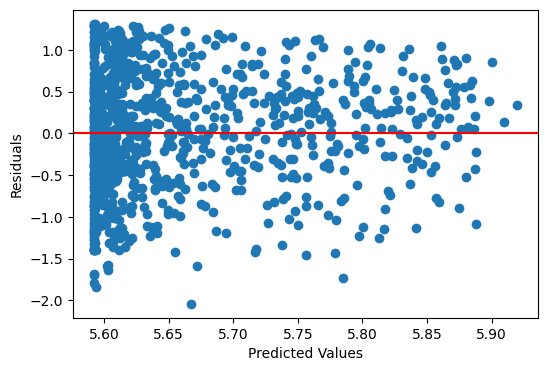

In [9]:
from keras import layers
from keras import regularizers

# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),

    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    # layers.Dropout(0.2),
    # layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    # layers.Dropout(0.2),
    # layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Output layer
    layers.Dense(1, activation='linear')
])

# Compile the model for regression
ff_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# tf.optimizers.Adam(learning_rate=1e-3)
#model.summary()

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
#history = ff_model.fit(training_data, epochs = 150, validation_data=(X_val_noisy, y_val))
#history = ff_model.fit(X_low_vis_train, y_low_vis_train_scaled, epochs = 50, validation_data=(X_low_vis_val, y_low_vis_val_scaled))
history = ff_model.fit(X_low_vis_train, y_low_vis_train, epochs = 50, validation_data=(X_low_vis_val, y_low_vis_val))


# y_pred = ff_model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# residuals = y_test - y_pred
# print(f'Mean squared error: {mse}')

y_pred = ff_model.predict(X_low_vis_test)
#mse = mean_squared_error(y_low_vis_test_scaled, y_pred)
mse = mean_squared_error(y_low_vis_test, y_pred)

residuals = y_low_vis_test - y_pred 
print(f'Mean squared error: {mse}')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Scatter Plot
plt.figure(figsize=(6, 4))
#plt.scatter(y_low_vis_test_scaled, y_pred)
plt.scatter(y_low_vis_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

  1/158 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean squared error: 1.5664931535720825


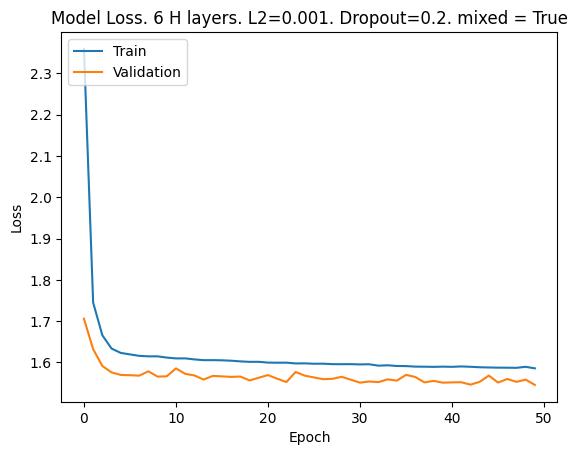

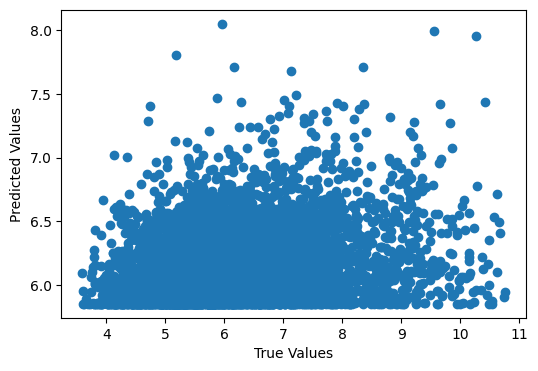

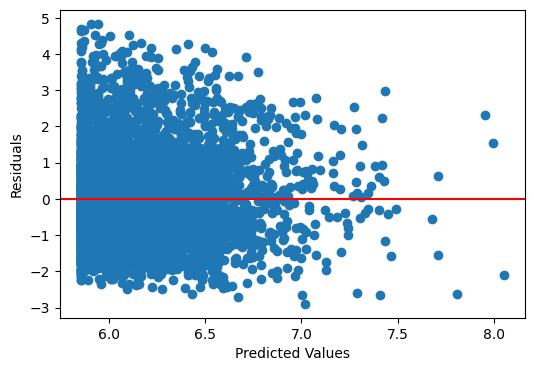

In [23]:
y_pred = ff_model.predict(X_low_vis_test)
mse = mean_squared_error(y_low_vis_test, y_pred)
residuals = y_low_vis_test - y_pred 
print(f'Mean squared error: {mse}')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_low_vis_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

Tabnet

/home/edgelab/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73769 | val_0_auc: 0.78765 |  0:00:00s
epoch 1  | loss: 0.48379 | val_0_auc: 0.84316 |  0:00:01s
epoch 2  | loss: 0.44894 | val_0_auc: 0.8545  |  0:00:01s
epoch 3  | loss: 0.42888 | val_0_auc: 0.86877 |  0:00:02s
epoch 4  | loss: 0.41115 | val_0_auc: 0.87171 |  0:00:02s
epoch 5  | loss: 0.39886 | val_0_auc: 0.88586 |  0:00:03s
epoch 6  | loss: 0.39222 | val_0_auc: 0.87935 |  0:00:03s
epoch 7  | loss: 0.38672 | val_0_auc: 0.8826  |  0:00:04s
epoch 8  | loss: 0.38543 | val_0_auc: 0.89496 |  0:00:04s
epoch 9  | loss: 0.37492 | val_0_auc: 0.89691 |  0:00:05s
epoch 10 | loss: 0.36736 | val_0_auc: 0.90099 |  0:00:05s
epoch 11 | loss: 0.36501 | val_0_auc: 0.89947 |  0:00:06s
epoch 12 | loss: 0.36368 | val_0_auc: 0.90034 |  0:00:06s
epoch 13 | loss: 0.3585  | val_0_auc: 0.90241 |  0:00:07s
epoch 14 | loss: 0.35671 | val_0_auc: 0.89732 |  0:00:08s
epoch 15 | loss: 0.35331 | val_0_auc: 0.90791 |  0:00:08s
epoch 16 | loss: 0.3494  | val_0_auc: 0.90893 |  0:00:09s
epoch 17 | los

/home/edgelab/.local/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2103
           1       0.60      0.75      0.67       397

    accuracy                           0.88      2500
   macro avg       0.77      0.83      0.80      2500
weighted avg       0.89      0.88      0.89      2500



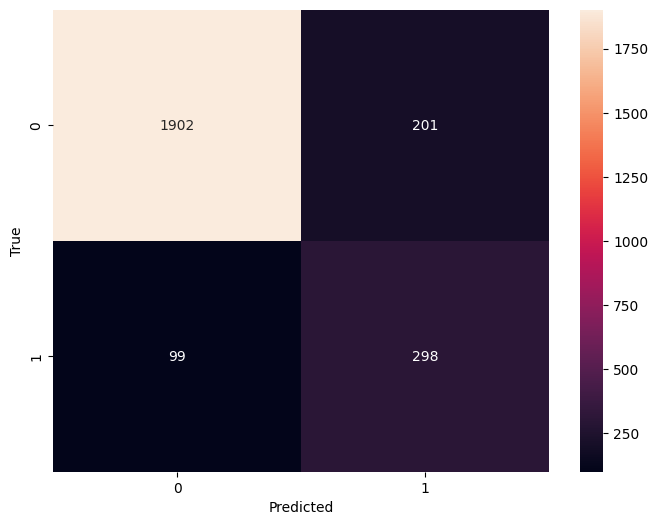

In [84]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

clf = TabNetClassifier()

clf.fit(
  X_train_noisy, y_train_class.ravel(), max_epochs=125,
  eval_set=[(X_val_noisy, y_val_class.ravel())]
)
preds = clf.predict(X_test_noisy)

print(classification_report(y_test_class, preds))
cm = confusion_matrix(y_test_class, preds)

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

DNN Classification with attention

Epoch 1/60


W0000 00:00:1710250305.272313 1197186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710250306.413427 1197180 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/135 - 4s - 29ms/step - accuracy: 0.7051 - loss: 0.6859 - val_accuracy: 0.7382 - val_loss: 0.6114
Epoch 2/60
135/135 - 0s - 4ms/step - accuracy: 0.7719 - loss: 0.5545 - val_accuracy: 0.7750 - val_loss: 0.5505
Epoch 3/60
135/135 - 0s - 4ms/step - accuracy: 0.7966 - loss: 0.5048 - val_accuracy: 0.7940 - val_loss: 0.5068
Epoch 4/60
135/135 - 0s - 4ms/step - accuracy: 0.8119 - loss: 0.4726 - val_accuracy: 0.8130 - val_loss: 0.4810
Epoch 5/60
135/135 - 0s - 3ms/step - accuracy: 0.8254 - loss: 0.4482 - val_accuracy: 0.8197 - val_loss: 0.4567
Epoch 6/60
135/135 - 1s - 4ms/step - accuracy: 0.8321 - loss: 0.4315 - val_accuracy: 0.8287 - val_loss: 0.4435
Epoch 7/60
135/135 - 0s - 4ms/step - accuracy: 0.8378 - loss: 0.4194 - val_accuracy: 0.8314 - val_loss: 0.4304
Epoch 8/60
135/135 - 0s - 4ms/step - accuracy: 0.8421 - loss: 0.4110 - val_accuracy: 0.8351 - val_loss: 0.4238
Epoch 9/60
135/135 - 0s - 3ms/step - accuracy: 0.8449 - loss: 0.4034 - val_accuracy: 0.8327 - val_loss: 0.4177
Epoch 10/60

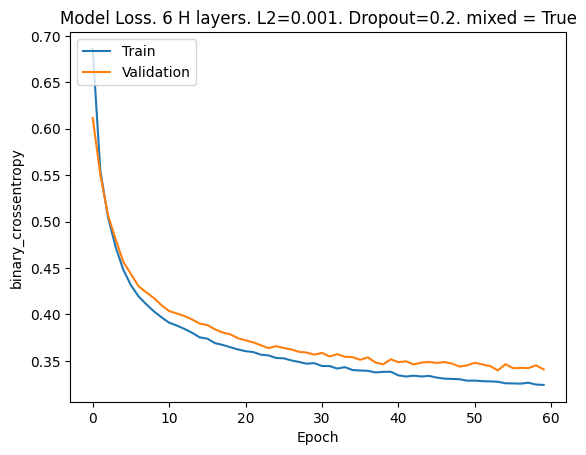

              precision    recall  f1-score   support

           0       0.98      0.91      0.94     13773
           1       0.44      0.83      0.58      1226

    accuracy                           0.90     14999
   macro avg       0.71      0.87      0.76     14999
weighted avg       0.94      0.90      0.91     14999



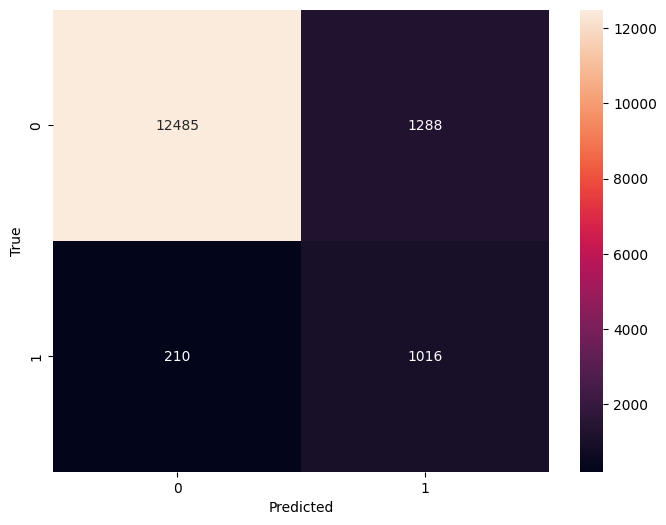

In [24]:
from keras import layers
from keras import regularizers
from keras.layers import Attention, Input, Flatten

# Define the input layer
input_layer = Input(shape=(len(features_i),))

# Hidden layers
hidden_layer_1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)

# Flatten the output of the hidden layer
flatten_layer = Flatten()(hidden_layer_1)

# Reshape to ensure it's 2D
reshaped_layer = layers.Reshape((1, -1))(flatten_layer)

# Attention layer
attention = Attention()([reshaped_layer, reshaped_layer])

# Additional hidden layers
hidden_layer_2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(attention)
hidden_layer_3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_2)
hidden_layer_4 = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_3)

# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(hidden_layer_4)

# Define the model
ff_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history = ff_model.fit(training_data_class, epochs = 60, validation_data=(X_val_noisy, y_val_class), verbose=2)

y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int).flatten()
cm = confusion_matrix(y_test_class, y_pred_label)

from sklearn.metrics import classification_report

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_class, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
from keras import layers
from keras import regularizers
from keras.layers import Attention, Input, Flatten

# Define the input layer
input_layer = Input(shape=(len(features_i),))

# Flatten the output of the input layer
flatten_layer = Flatten()(input_layer)

# Reshape to ensure it's 2D
reshaped_layer = layers.Reshape((1, -1))(flatten_layer)

# Attention layer
attention = Attention()([reshaped_layer, reshaped_layer])

# Hidden layers
hidden_layer_1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(attention)

# Additional hidden layers
hidden_layer_2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_1)
hidden_layer_3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_2)
hidden_layer_4 = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_3)

# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(hidden_layer_4)

# Define the model
ff_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

Epoch 1/60


W0000 00:00:1710250372.036359 1197182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710250375.858864 1197182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/135 - 9s - 66ms/step - accuracy: 0.6843 - loss: 0.7306 - val_accuracy: 0.7275 - val_loss: 0.6436
Epoch 2/60
135/135 - 1s - 4ms/step - accuracy: 0.7324 - loss: 0.6267 - val_accuracy: 0.7546 - val_loss: 0.5799
Epoch 3/60
135/135 - 1s - 5ms/step - accuracy: 0.7582 - loss: 0.5672 - val_accuracy: 0.7836 - val_loss: 0.5245
Epoch 4/60
135/135 - 1s - 4ms/step - accuracy: 0.7816 - loss: 0.5190 - val_accuracy: 0.8080 - val_loss: 0.4818
Epoch 5/60
135/135 - 1s - 4ms/step - accuracy: 0.8006 - loss: 0.4819 - val_accuracy: 0.8207 - val_loss: 0.4479
Epoch 6/60
135/135 - 1s - 4ms/step - accuracy: 0.8141 - loss: 0.4542 - val_accuracy: 0.8357 - val_loss: 0.4206
Epoch 7/60
135/135 - 1s - 4ms/step - accuracy: 0.8216 - loss: 0.4395 - val_accuracy: 0.8354 - val_loss: 0.4115
Epoch 8/60
135/135 - 1s - 4ms/step - accuracy: 0.8258 - loss: 0.4263 - val_accuracy: 0.8414 - val_loss: 0.3972
Epoch 9/60
135/135 - 1s - 4ms/step - accuracy: 0.8304 - loss: 0.4168 - val_accuracy: 0.8407 - val_loss: 0.3957
Epoch 10/60

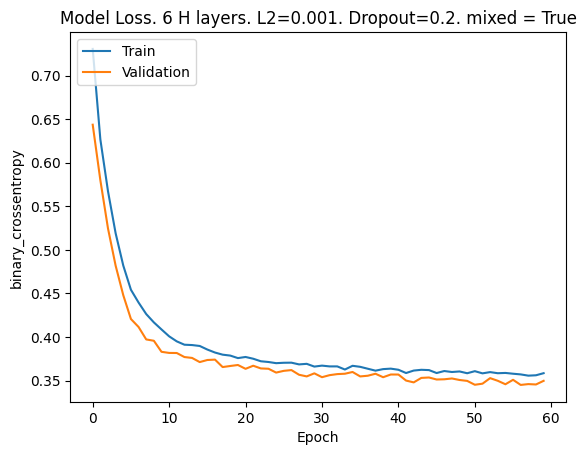

              precision    recall  f1-score   support

           0       0.98      0.91      0.94     13773
           1       0.45      0.81      0.57      1226

    accuracy                           0.90     14999
   macro avg       0.71      0.86      0.76     14999
weighted avg       0.94      0.90      0.91     14999



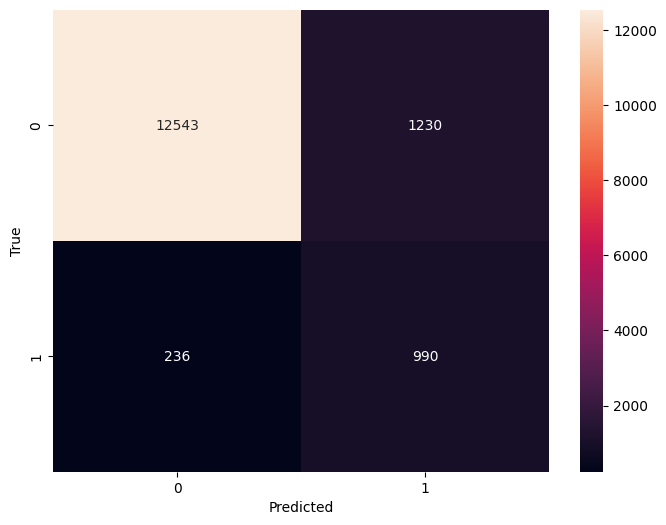

In [26]:
from keras import layers
from keras import regularizers
from keras.layers import Attention, Input, Reshape

# Define the input layer
input_layer = Input(shape=(len(features_i),))

# Reshape input to include a singleton dimension for timestep
reshaped_input = Reshape((1, len(features_i)))(input_layer)

# Attention layer
attention = Attention()([reshaped_input, reshaped_input])

# Flatten the attention output to merge the timestep dimension
flattened_attention = layers.Flatten()(attention)
dropout_0 = layers.Dropout(0)(flattened_attention)


# Hidden layers
hidden_layer_1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_0)
dropout_1 = layers.Dropout(0.2)(hidden_layer_1)
hidden_layer_2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_1)
dropout_2 = layers.Dropout(0.2)(hidden_layer_2)
hidden_layer_3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_2)
dropout_3 = layers.Dropout(0.2)(hidden_layer_3)
hidden_layer_4 = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_3)

# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(hidden_layer_4)

# Define the model
ff_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

history = ff_model.fit(training_data_class, epochs = 60, validation_data=(X_val_noisy, y_val_class), verbose=2)


y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_class, y_pred_label)

from sklearn.metrics import classification_report

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_class, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

DNN for regression with Multi head attention

Epoch 1/60


W0000 00:00:1710250425.297174 1197187 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710250429.631227 1197182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/135 - 11s - 80ms/step - accuracy: 0.6597 - loss: 0.7124 - val_accuracy: 0.7205 - val_loss: 0.6096
Epoch 2/60
135/135 - 1s - 4ms/step - accuracy: 0.7267 - loss: 0.5799 - val_accuracy: 0.7346 - val_loss: 0.5577
Epoch 3/60
135/135 - 1s - 4ms/step - accuracy: 0.7452 - loss: 0.5395 - val_accuracy: 0.7526 - val_loss: 0.5198
Epoch 4/60
135/135 - 1s - 4ms/step - accuracy: 0.7766 - loss: 0.4883 - val_accuracy: 0.7963 - val_loss: 0.4582
Epoch 5/60
135/135 - 1s - 4ms/step - accuracy: 0.8009 - loss: 0.4545 - val_accuracy: 0.8144 - val_loss: 0.4367
Epoch 6/60
135/135 - 1s - 4ms/step - accuracy: 0.8063 - loss: 0.4400 - val_accuracy: 0.8170 - val_loss: 0.4285
Epoch 7/60
135/135 - 1s - 4ms/step - accuracy: 0.8134 - loss: 0.4285 - val_accuracy: 0.8224 - val_loss: 0.4211
Epoch 8/60
135/135 - 1s - 4ms/step - accuracy: 0.8164 - loss: 0.4231 - val_accuracy: 0.8214 - val_loss: 0.4231
Epoch 9/60
135/135 - 1s - 4ms/step - accuracy: 0.8173 - loss: 0.4200 - val_accuracy: 0.8224 - val_loss: 0.4140
Epoch 10/6

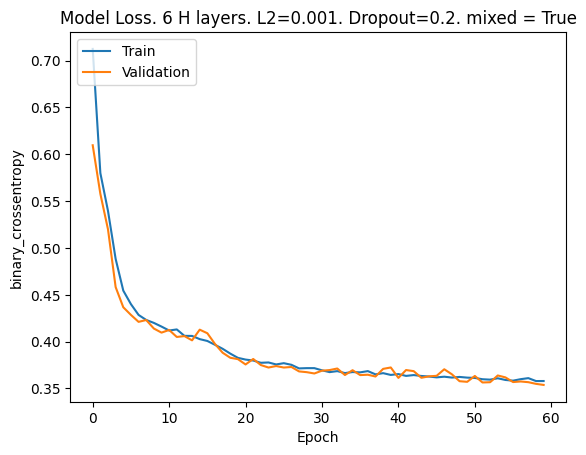

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     13773
           1       0.42      0.79      0.55      1226

    accuracy                           0.89     14999
   macro avg       0.70      0.85      0.74     14999
weighted avg       0.93      0.89      0.91     14999



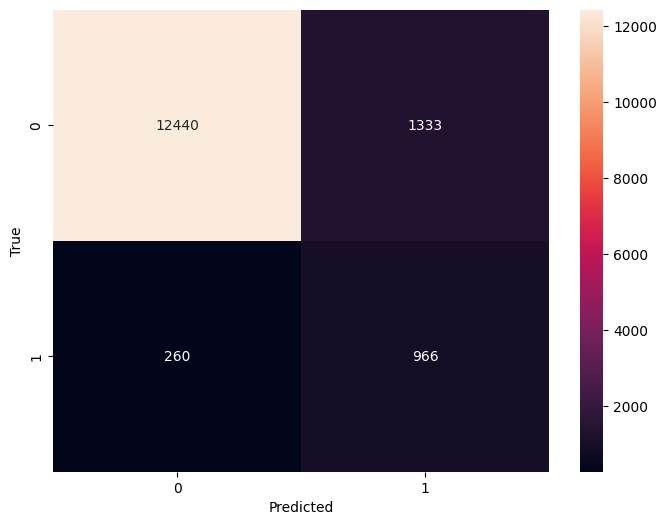

In [27]:
from keras import layers
from keras import regularizers
from keras.layers import MultiHeadAttention, Input, Reshape

input_layer = Input(shape=(len(features_i),))

# Reshape input to include a singleton dimension for timestep
reshaped_input = Reshape((1, len(features_i)))(input_layer)

# Multi-head Attention layer
multi_head_attention = MultiHeadAttention(num_heads=4, key_dim=2)(reshaped_input, reshaped_input)

# Flatten the multi-head attention output to merge the timestep dimension
flattened_attention = layers.Flatten()(multi_head_attention)
#dropout_0 = layers.Dropout(0)(flattened_attention)

# Hidden layers
hidden_layer_1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(flattened_attention)
dropout_1 = layers.Dropout(0.2)(hidden_layer_1)
hidden_layer_2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_1)
dropout_2 = layers.Dropout(0.2)(hidden_layer_2)
hidden_layer_3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_2)
dropout_3 = layers.Dropout(0.2)(hidden_layer_3)
hidden_layer_4 = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_3)

# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(hidden_layer_4)

# Define the model
ff_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

history = ff_model.fit(training_data_class, epochs=60, validation_data=(X_val_noisy, y_val_class), verbose=2)

y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_class, y_pred_label)

from sklearn.metrics import classification_report

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_class, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
